# Linear Model Fitting using empirical variogram
In classical geoestatistics it is frequent to use a sample-based variogram to fit a parametrised theoretical variogram. This method has proved to present biasses for the estimators of range, sill and shape. There are two reasons for this.
1. We are supposing that the observations are not random and the variogram is the true population variogram. 
2. The variogram is built on summary statistics (bin size) and the curve-fitness can vary depending on this size. 

Having said so, it is still a method used for estimating parameters and when the size of the data is big, being a good alternative to the likelihood methodology, a more robust optimization but computationally more complex. 

So first thing first, import the neessary modules. Depending on your machine this may change.
For the moment I work with this.

In [1]:
# Load Biospytial modules and etc.
%matplotlib inline
import sys
sys.path.append('/apps')
sys.path.append('/apps/external_plugins/spystats/')
import django
django.setup()

## Use the ggplot style
plt.style.use('ggplot')


In [6]:
import pandas as pd
from statsmodels.regression import linear_model
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import tools
import HEC_runs.fit_fia_logbiomass_logspp_GLS as auxiliary

In [7]:
## File locations, change accordingly
empirical_data_path = "/RawDataCSV/idiv_share/FIA_Plots_Biomass_11092017.csv"
variogram_path = "/apps/external_plugins/spystats/HEC_runs/results/variogram/data_envelope.csv"


## Geographic extent 

In [11]:
minx = -130
maxx = -60
miny = 24
maxy = 50

### Auxiliary functions
    * Open file
    * Convert it to Pandas with Geometry (GeoPandas)
    * Reproject it to Lambert Conic Conformal
    * Calculate OLS and append residuals

In [13]:
data = auxiliary.initAnalysis(empirical_data_path=empirical_data_path,plotdata_path=plotdata_path, maxx=maxx,minx=minx,maxy=maxy,miny=miny)

INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:Reprojecting to Alberts equal area
INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:Removing possible duplicates. 
 This avoids problems of Non Positive semidefinite
INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:Fitting OLS linear model: logBiomass ~ logSppN 
INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:Subselecting Region


### For testing, subselect the first 50 data points

In [17]:
test_data = data.loc[0:50,:]

## Now lets instantiate the variogram according to the results obtained in the cluster.
Remember:
    < Whittle Variogram : sill 0.340246718396, range 41188.0234423, nugget 0.329937603763, alpha1.12143687914 >

In [23]:
model = tools.WhittleVariogram(sill=0.340246718396,range_a=41188.0234423,nugget=0.329937603763,alpha=1.12143687914)

### Let's see the correlation

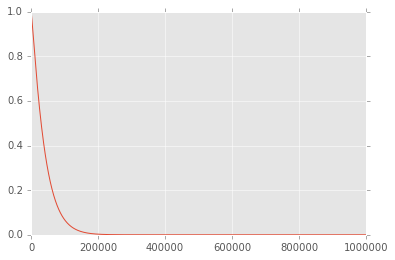

In [44]:
import numpy as np
X = np.linspace(0,1000000,1000)
plt.plot(X,model.corr_f(X))

In [27]:
vg = tools.Variogram(test_data,'residuals',model=model)
MM = vg.calculateCovarianceMatrix()

### Fit a GLS 

In [45]:
lmod = linear_model.GLS.from_formula(formula='logBiomass ~ logSppN',data=test_data,sigma=MM)

In [50]:
results = lmod.fit()

In [51]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:             logBiomass   R-squared:                       0.753
Model:                            GLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     149.1
Date:                Thu, 08 Feb 2018   Prob (F-statistic):           1.78e-16
Time:                        17:31:44   Log-Likelihood:                -38.132
No. Observations:                  51   AIC:                             80.26
Df Residuals:                      49   BIC:                             84.13
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      8.4662      0.157     53.811      0.000         8.150     8.782
logSppN        0.3415      0.096      3.558      0.001         0.149     0.534
==============================================================================
Omnibus:                        0.567   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.753   Jarque-Bera (JB):                0.667
Skew:                          -0.223   Prob(JB):                        0.716
Kurtosis:                       2.661   Cond. No.                         3.85
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""